# TRAIN : YOLO v5x

* KFOLD

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import shutil, os, sys
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import cv2
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# import 한 파일들 체크

In [35]:
# 1. yolo txt : yolo 에 input 할 label. class 와 비율(x,y,w,h)
f = open(glob('/home/madquer/programming/kaggle/siim/data/yolotxt/*')[1], 'r')
f.read()

'0 0.28465117595204514 0.4858831827910959 0.3590698201692525 0.6121025984589041 \n0 0.6283720962623413 0.5660663848458904 0.298604643864598 0.591774430650685 \n'

In [37]:
# 2. covid19 512 img : 512 px img_size -> img_level, study_level 각 이미지
# 3. yolov5-1-yaml : yolo v5 학습을 위한 구성 요소
import yaml
with open('/home/madquer/programming/kaggle/siim/code/image_level_code/hyp.scratch.yaml') as f:
    y = yaml.load(f)
y
# 4. yolov5 package : like mmdetection : 만약 제대로 내가 코드를 짠다면, 불러와서 다시 짜기

<ipython-input-37-b752aa819cfd>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  y = yaml.load(f)


{'lr0': 0.01,
 'lrf': 0.032,
 'momentum': 0.937,
 'weight_decay': 0.0005,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'warmup_bias_lr': 0.1,
 'box': 0.1,
 'cls': 1.0,
 'cls_pw': 0.5,
 'obj': 2.0,
 'obj_pw': 0.5,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'anchors': 0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'degrees': 0.0,
 'translate': 0.2,
 'scale': 0.6,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.2,
 'fliplr': 0.5,
 'mosaic': 1.0,
 'mixup': 0.0}

In [38]:
fold = 0
train_df = pd.read_csv('/home/madquer/programming/kaggle/siim/data/resized_data/new_resized_data/new_df.csv')

df = train_df

gkf = GroupKFold(n_splits=5)
df['fold'] = -1
for fold, (train_index, valid_index) in enumerate(gkf.split(df, groups = df.StudyInstanceUID.tolist())):
    df.loc[valid_index, 'fold'] = fold

train_df = df

train_df['image_path'] = f"/home/madquer/programming/kaggle/siim/data/resized_data/new_resized_data/image_512/" + train_df['id'] + '.png'
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  fold  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75     0   
1                                     none 1 0 0 1 1     ff0879eb20ed     2   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7     4   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2     1   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e     0   

                                          image_path  
0  /home/madquer/programming/kaggle/siim/data/res...  
1  /home/madquer/programming/kaggle/siim/data/res...  
2  /home/madquer/programming/kaggle/siim/data/res...  
3  /home/madquer/programming/kaggle/siim/data/res...  
4  /home/madquer/programming/kaggle/siim/data/res...

In [39]:
train_df['fold'].value_counts()

0    1224
1    1224
4    1223
2    1223
3    1223
Name: fold, dtype: int64

In [40]:
train_df['class'] = train_df['label'].apply(lambda x: 'opacity' if x[0] == 'o' else 'none')
for i in range(5):
    temp = train_df[train_df['fold']==i]['class'].value_counts()
    print(f"fold {i}")
    print(f"\topacity ratio : {(temp[0])/(temp[0]+temp[1])*100:.0f} %")
    print(f"\tnone ratio    : {(temp[1])/(temp[0]+temp[1])*100:.0f} %")
# 비율이 엄청 차이나지는 않기 때문에 image level 에서의 box 예측은 큰 문제가 되지는 않을 것 같다.

fold 0
	opacity ratio : 69 %
	none ratio    : 31 %
fold 1
	opacity ratio : 71 %
	none ratio    : 29 %
fold 2
	opacity ratio : 69 %
	none ratio    : 31 %
fold 3
	opacity ratio : 71 %
	none ratio    : 29 %
fold 4
	opacity ratio : 71 %
	none ratio    : 29 %


In [41]:
temp = train_df[train_df['fold']==i]['class'].value_counts()
temp[0], temp[1]

(863, 360)

In [42]:
classes = ['0. opacity']
train_files = []
valid_files = []
for fold in range(5):
    valid_files += [train_df[train_df['fold']==fold]['image_path'].unique().tolist()]
    train_files += [train_df[train_df['fold']!=fold]['image_path'].unique().tolist()]
len(train_files), len(valid_files)

(5, 5)

# Copying Files
* shutil
```py
shutil.copy(원본 경로, 대상 경로)
shutil.copyfile(원본 파일 경로, 대상 파일 경로) # 원본이 파일이 아닌 폴더이면 에러 발생
shutil.copytree(원본 폴더 경로, 대상 폴더 경로) # 원본이 폴더가 아닌 파일이면 에러 발생
```

In [43]:
# shutil : 파일을 복사
kfold = True
img_size = 768
path = f'/home/madquer/programming/kaggle/siim/working/new_data_{img_size}'

if kfold:
    if os.path.isdir(path):
        shutil.rmtree(path)

tmp = path
for i in range(5):
    print(f"----- fold {i} -----")
    tmp_fold = tmp + f"/fold_{img_size}_{i}"
    os.makedirs(tmp_fold, exist_ok=True)

    tmp_labels_train = tmp_fold + '/labels/train'
    tmp_labels_val = tmp_fold + '/labels/val'
    tmp_images_train = tmp_fold + '/images/train'
    tmp_images_val = tmp_fold + '/images/val'

    os.makedirs(tmp_labels_train, exist_ok = True)
    os.makedirs(tmp_labels_val, exist_ok = True)
    os.makedirs(tmp_images_train, exist_ok = True)
    os.makedirs(tmp_images_val, exist_ok = True)
    
    label_dir = '/home/madquer/programming/kaggle/siim/data/yolotxt' # x, y, w, h
    # label_dir : seperated txt files for yoloV5
    
    # train
    for file in tqdm(train_files[i]):
        # image
        shutil.copy(src = file, 
                    dst = tmp_images_train)
        # label : yolo txt 에 맞게 파일 이름 매칭 시켜 복사
        filename = file.split('/')[-1].split('.')[0]
        shutil.copy(src = os.path.join(label_dir, filename+'.txt'),
                    dst = tmp_labels_train)

    # valid
    for file in tqdm(valid_files[i]):
        shutil.copy(src = file,
                    dst = tmp_images_val)
        filename = file.split('/')[-1].split('.')[0]
        shutil.copy(src = os.path.join(label_dir, filename+'.txt'),
                    dst = tmp_labels_val)



----- fold 0 -----


  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/1224 [00:00<?, ?it/s]

----- fold 1 -----


  0%|          | 0/4893 [00:00<?, ?it/s]

  0%|          | 0/1224 [00:00<?, ?it/s]

----- fold 2 -----


  0%|          | 0/4894 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

----- fold 3 -----


  0%|          | 0/4894 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

----- fold 4 -----


  0%|          | 0/4894 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

# Get Class Name

# Yolov5 Stuff

In [44]:
import os
import yaml

classes = ['0. opacity']
cwd = f"/home/madquer/programming/kaggle/siim/working/new_data_{img_size}"

for i in range(5):
    with open(os.path.join(cwd, f'train_{i}.txt'), 'w') as f:
        for path in glob(cwd + f'/fold_{img_size}_{i}/images/train/*'):
            f.write(path+'\n')
    with open(os.path.join(cwd, f'val_{i}.txt'), 'w') as f:
        for path in glob(cwd + f'/fold_{img_size}_{i}/images/val/*'):
            f.write(path+'\n')

    data = dict(train = os.path.join(cwd, f'train_{i}.txt'),
                val = os.path.join(cwd, f'val_{i}.txt'),
                nc = 1, # nc 가 뭐지? 나중에 코드를 봐야겠다.
                names = classes)

    with open(os.path.join(cwd, f'fold_{i}.yaml'), 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)

    f = open(os.path.join(cwd, f'fold_{i}.yaml'), 'r')
    print('\n---yaml file---')
    print(f.read())


---yaml file---
names:
- 0. opacity
nc: 1
train: /home/madquer/programming/kaggle/siim/working/new_data_768/train_0.txt
val: /home/madquer/programming/kaggle/siim/working/new_data_768/val_0.txt


---yaml file---
names:
- 0. opacity
nc: 1
train: /home/madquer/programming/kaggle/siim/working/new_data_768/train_1.txt
val: /home/madquer/programming/kaggle/siim/working/new_data_768/val_1.txt


---yaml file---
names:
- 0. opacity
nc: 1
train: /home/madquer/programming/kaggle/siim/working/new_data_768/train_2.txt
val: /home/madquer/programming/kaggle/siim/working/new_data_768/val_2.txt


---yaml file---
names:
- 0. opacity
nc: 1
train: /home/madquer/programming/kaggle/siim/working/new_data_768/train_3.txt
val: /home/madquer/programming/kaggle/siim/working/new_data_768/val_3.txt


---yaml file---
names:
- 0. opacity
nc: 1
train: /home/madquer/programming/kaggle/siim/working/new_data_768/train_4.txt
val: /home/madquer/programming/kaggle/siim/working/new_data_768/val_4.txt



In [45]:
# https://www.kaggle.com/ultralytics/yolov5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5

result_path = f'/home/madquer/programming/kaggle/siim/working/result_{img_size}'

if os.path.isdir(result_path):
    shutil.rmtree(result_path)
else:
    os.makedirs(result_path)

for i in range(5):
    shutil.copytree(src = '/home/madquer/programming/kaggle/siim/code/image_level_code/yolo_v5/yolov5',
                    dst = result_path + f'/fold_{img_size}_{i}/yolo')
    print(f'Copy yolo data for fold {i}')
# %pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output # to display images

clear_output()

In [46]:
print(f'Setup complete. Using torch {torch.__version__} \
\n{torch.cuda.get_device_properties(0) if torch.cuda.is_available() else "CPU"}')

Setup complete. Using torch 1.8.1 
_CudaDeviceProperties(name='GeForce RTX 3070', major=8, minor=6, total_memory=7979MB, multi_processor_count=46)


In [47]:
os.chdir(f'/home/madquer/programming/kaggle/siim/working/result/fold_0/yolo') # terminal 명령어 바로 실행을 위한 change directory

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5s.pt'])
Using torch 1.8.1 CUDA:0 (GeForce RTX 3070, 7979.1875MB)

100%|██████████████████████████████████████| 14.5M/14.5M [00:02<00:00, 6.27MB/s]

Fusing layers... 
Model Summary: 232 layers, 7459581 parameters, 0 gradients
image 1/2 /home/madquer/programming/kaggle/siim/working/result/fold_0/yolo/data/images/bus.jpg: 640x480 4 persons, 1 buss, 1 skateboards, Done. (0.011s)
image 2/2 /home/madquer/programming/kaggle/siim/working/result/fold_0/yolo/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.011s)
Results saved to runs/detect/exp
Done. (0.091s)


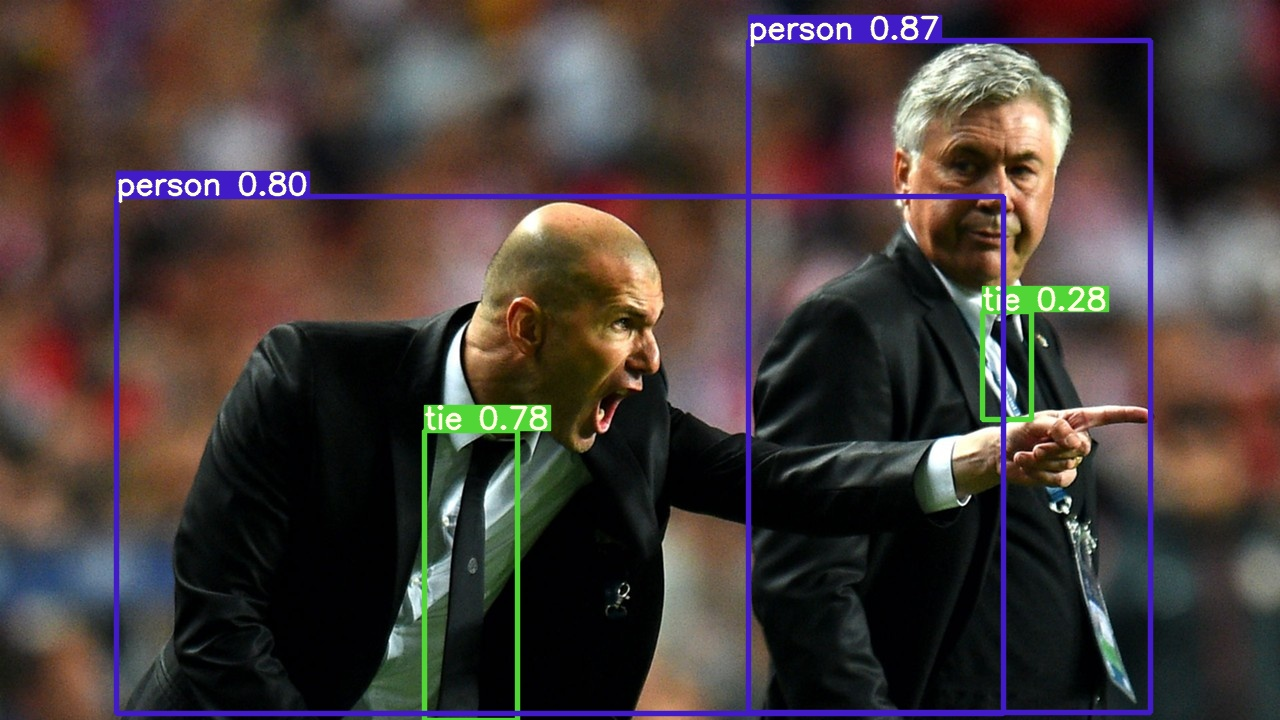

In [43]:
# sample test
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

[Compare Pretrained models](https://github.com/ultralytics/yolov5/releases/tag/v3.0)

# Selecting Models
In this notebook I'm using `v5s`. To select your prefered model just replace  
`--cfg models/yolov5s.yaml --weights yolov5s.pt` with the following command:  
* `v5s` : `--cfg models/yolov5s.yaml --weights yolov5s.pt`
* `v5m` : `--cfg models/yolov5m.yaml --weights yolov5m.pt`
* `v5l` : `--cfg models/yolov5l.yaml --weights yolov5l.pt`
* `v5x` : `--cfg models/yolov5x.yaml --weights yolov5x.pt`

# Train

In [3]:
#!pip install tensorboard
import tensorboard

### KFOLD TRAININING

In [ ]:
# shell command
#cd /home/madquer/programming/kaggle/siim/working/result/fold_0/yolo
#WANDB_MODE="disabled" python train.py --img 512 --batch 6 --epochs 70 --data /home/madquer/programming/kaggle/siim/working/tmp_data/fold_0.yaml --hyp /home/madquer/programming/kaggle/siim/code/image_level_code/hyp.scratch.yaml --weights yolov5x.pt --cache

In [ ]:
# training command 1024 kfold
# cd /home/madquer/programming/kaggle/siim/working/result_768/fold_768_0/yolo
# WANDB="disabled" python train.py --img 768 --batch 2 --epochs 55 --data /home/madquer/programming/kaggle/siim/working/new_data_768/fold_0.yaml --hyp /home/madquer/programming/kaggle/siim/code/image_level_code/hyp.scratch.yaml --weights yolov5x.pt --cache


In [37]:
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
# !WANDB_MODE="dryrun" python train.py --img 512 --batch 24 --epochs 35 --data /kaggle/working/siim-cov19.yaml --hyp /kaggle/input/yolov5-1-yaml/hyp.scratch.yaml --weights yolov5x.pt --cache

# Training FOLD 0
os.chdir(f'/home/madquer/programming/kaggle/siim/working/result/fold_0/yolo')
!WANDB_MODE="disabled" python train.py --img 512 --batch 6 --epochs 50 --data /home/madquer/programming/kaggle/siim/working/tmp_data/fold_0.yaml --hyp /home/madquer/programming/kaggle/siim/code/image_level_code/hyp.scratch.yaml --weights yolov5x.pt --cache

/bin/sh: 1: git: not found
Traceback (most recent call last):
  File "train.py", line 469, in <module>
    check_git_status()
  File "/home/madquer/programming/kaggle/siim/working/result/yolo/utils/general.py", line 51, in check_git_status
    s = subprocess.check_output('if [ -d .git ]; then git fetch && git status -uno; fi', shell=True).decode('utf-8')
  File "/home/madquer/anaconda3/envs/data/lib/python3.8/subprocess.py", line 415, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/home/madquer/anaconda3/envs/data/lib/python3.8/subprocess.py", line 516, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command 'if [ -d .git ]; then git fetch && git status -uno; fi' returned non-zero exit status 127.


In [5]:
# Training FOLD 1
os.chdir(f'/home/madquer/programming/kaggle/siim/working/result/fold_1/yolo')
!WANDB_MODE="disabled" python train.py --img 512 --batch 6 --epochs 50 --data /home/madquer/programming/kaggle/siim/working/tmp_data/fold_1.yaml --hyp /home/madquer/programming/kaggle/siim/code/image_level_code/hyp.scratch.yaml --weights yolov5x.pt --cache

Using torch 1.8.1 CUDA:0 (GeForce RTX 3070, 7979.1875MB)

Namespace(adam=False, batch_size=6, bucket='', cache_images=True, cfg='', data='/home/madquer/programming/kaggle/siim/working/tmp_data/fold_1.yaml', device='', epochs=50, evolve=False, exist_ok=False, global_rank=-1, hyp='/home/madquer/programming/kaggle/siim/code/image_level_code/hyp.scratch.yaml', image_weights=False, img_size=[512, 512], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=6, weights='yolov5x.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'lrf': 0.032, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.1, 'cls': 1.0, 'cls_pw': 0.5, 'obj': 2.0, 

In [7]:
# Training FOLD 2
os.chdir(f'/home/madquer/programming/kaggle/siim/working/result/fold_2/yolo')
!WANDB_MODE="disabled" python train.py --img 512 --batch 6 --epochs 50 --data /home/madquer/programming/kaggle/siim/working/tmp_data/fold_2.yaml --hyp /home/madquer/programming/kaggle/siim/code/image_level_code/hyp.scratch.yaml --weights yolov5x.pt --cache

ckCSP             [320, 320, 12]                
  5                -1  1   1844480  models.common.Conv                      [320, 640, 3, 2]              
  6                -1  1  13228160  models.common.BottleneckCSP             [640, 640, 12]                
  7                -1  1   7375360  models.common.Conv                      [640, 1280, 3, 2]             
  8                -1  1   4099840  models.common.SPP                       [1280, 1280, [5, 9, 13]]      
  9                -1  1  20087040  models.common.BottleneckCSP             [1280, 1280, 4, False]        
 10                -1  1    820480  models.common.Conv                      [1280, 640, 1, 1]             
 11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 12           [-1, 6]  1         0  models.common.Concat                    [1]                           
 13                -1  1   5435520  models.common.BottleneckCSP             [1280, 640, 4, Fals

In [6]:
torch.cuda.empty_cache()

In [ ]:
# yolov5x : 50 epochs : 3.5 hrs

# Class Distribution
yolov5s : 1 epoch 90 s

In [56]:
glob('/kaggle/working/yolov5/runs/train/exp5/*')

['/kaggle/working/yolov5/runs/train/exp5/opt.yaml',
 '/kaggle/working/yolov5/runs/train/exp5/train_batch1.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/events.out.tfevents.1624478298.c9f1a4a32928.4280.0',
 '/kaggle/working/yolov5/runs/train/exp5/weights',
 '/kaggle/working/yolov5/runs/train/exp5/confusion_matrix.png',
 '/kaggle/working/yolov5/runs/train/exp5/results.txt',
 '/kaggle/working/yolov5/runs/train/exp5/test_batch1_pred.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/results.png',
 '/kaggle/working/yolov5/runs/train/exp5/labels.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/test_batch2_pred.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/train_batch0.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/test_batch1_labels.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/test_batch0_pred.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/precision_recall_curve.png',
 '/kaggle/working/yolov5/runs/train/exp5/test_batch2_labels.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/test_batch0_labels.j

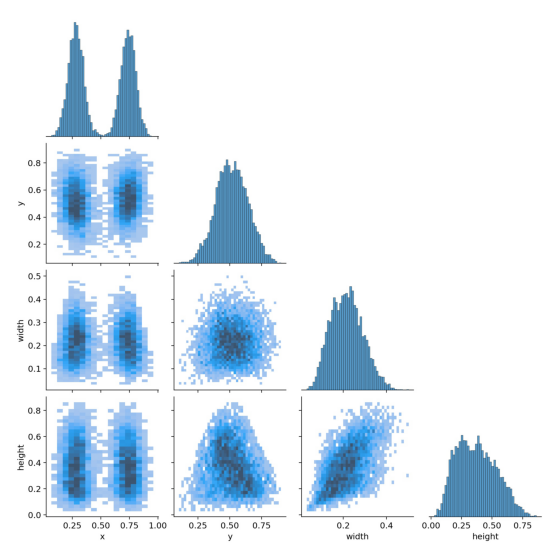

In [63]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp5/labels_correlogram.jpg'))

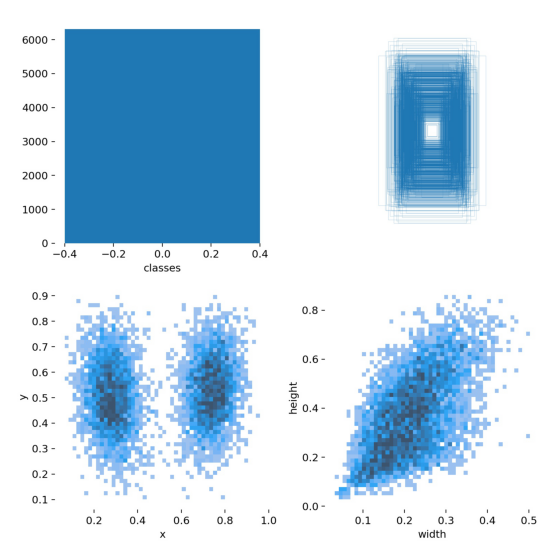

In [64]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp5/labels.jpg'))

# Batch Image

In [67]:
glob('/kaggle/working/yolov5/runs/train/exp5/train*')

['/kaggle/working/yolov5/runs/train/exp5/train_batch1.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/train_batch0.jpg',
 '/kaggle/working/yolov5/runs/train/exp5/train_batch2.jpg']

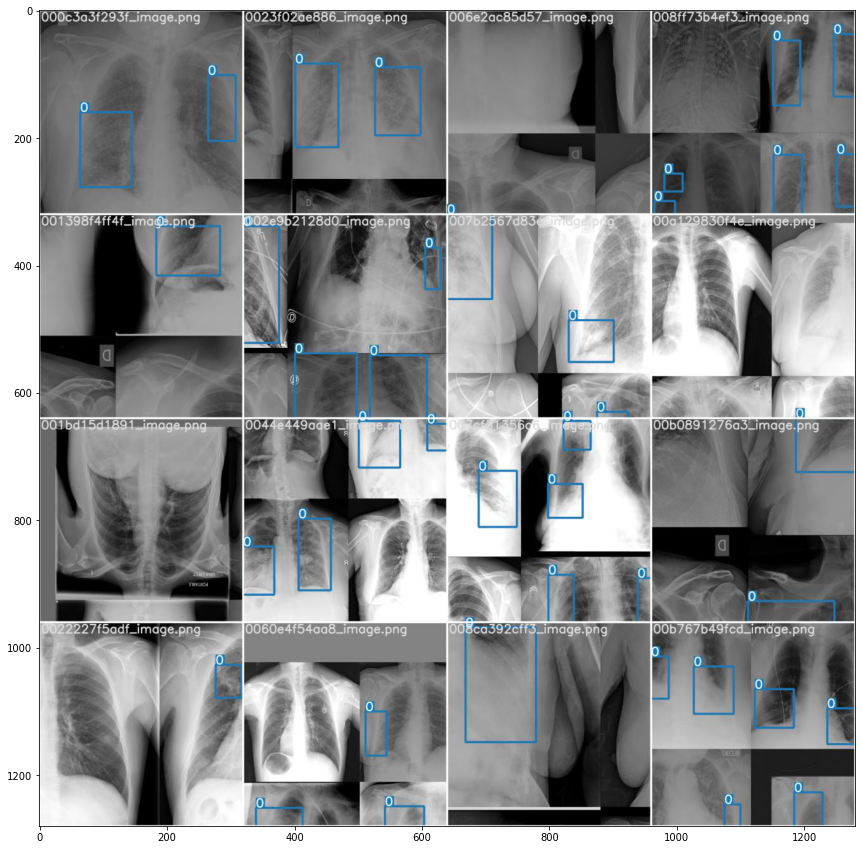

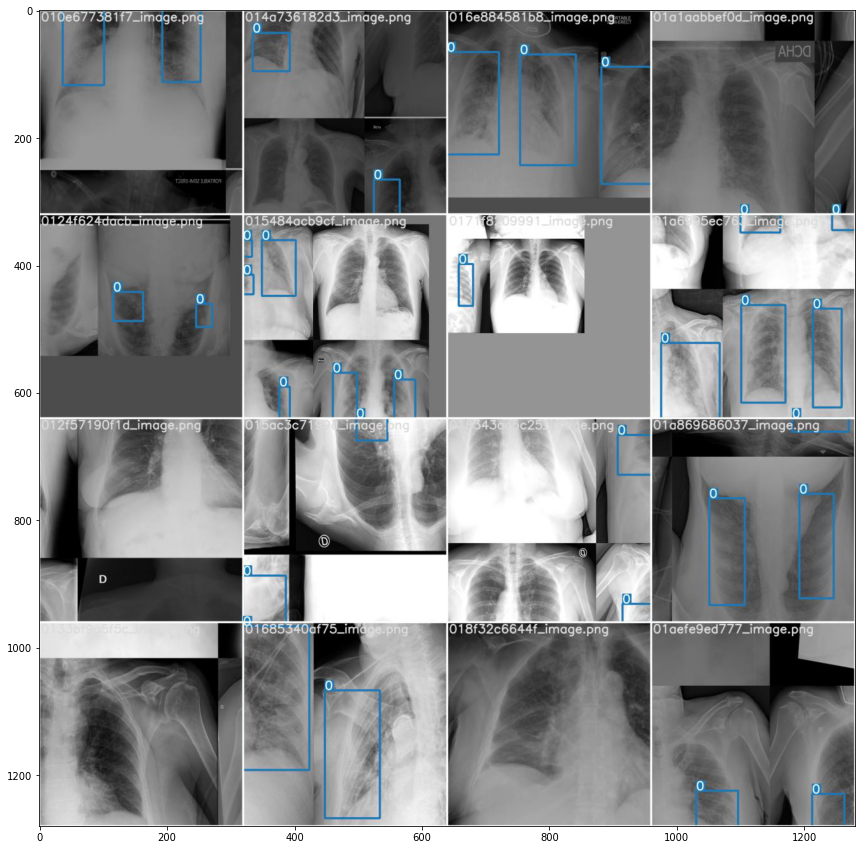

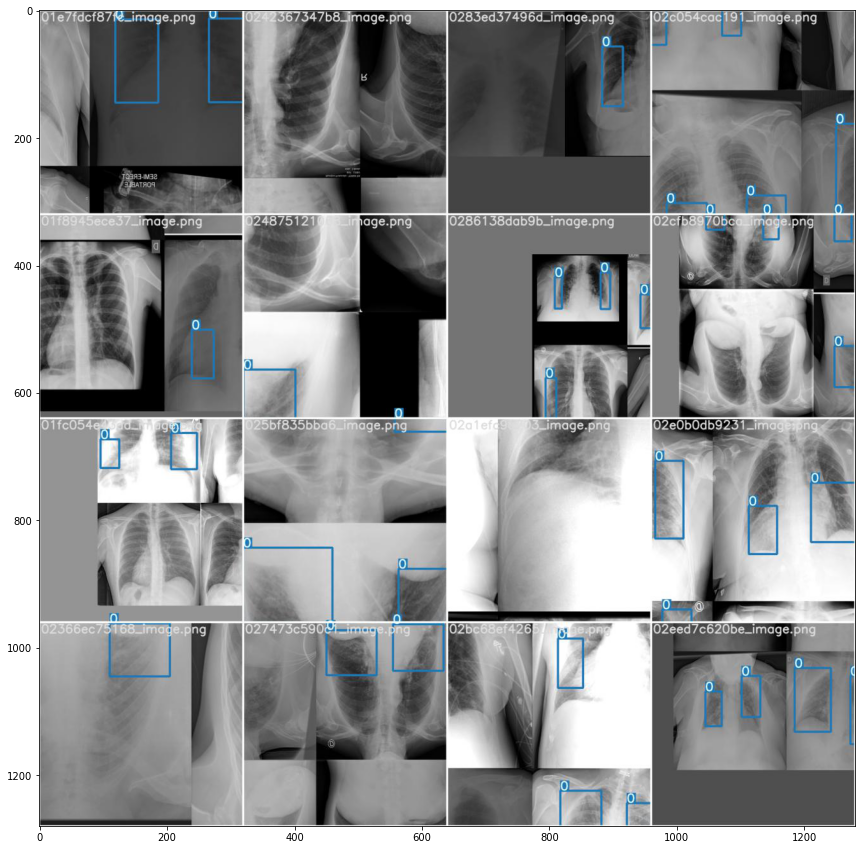

In [71]:
plt.figure(figsize = (15,15))
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp5/train_batch0.jpg'))
plt.figure(figsize = (15,15))
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp5/train_batch1.jpg'))
plt.figure(figsize = (15,15))
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp5/train_batch2.jpg'))

# GT Vs Pred

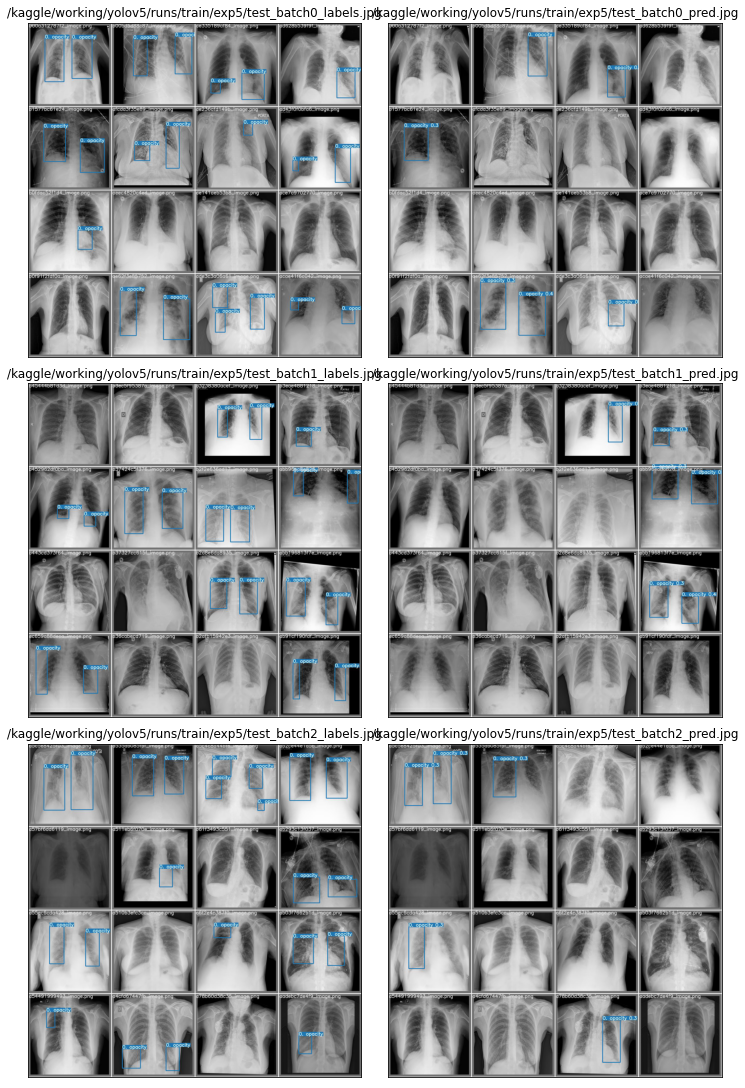

In [76]:
fig, ax = plt.subplots(3,2, figsize=(2*5, 3*5), constrained_layout=True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'/kaggle/working/yolov5/runs/train/exp5/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/kaggle/working/yolov5/runs/train/exp5/test_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'/kaggle/working/yolov5/runs/train/exp5/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/kaggle/working/yolov5/runs/train/exp5/test_batch{row}_pred.jpg', fontsize = 12)

# (Loss, Map) Vs Epoch

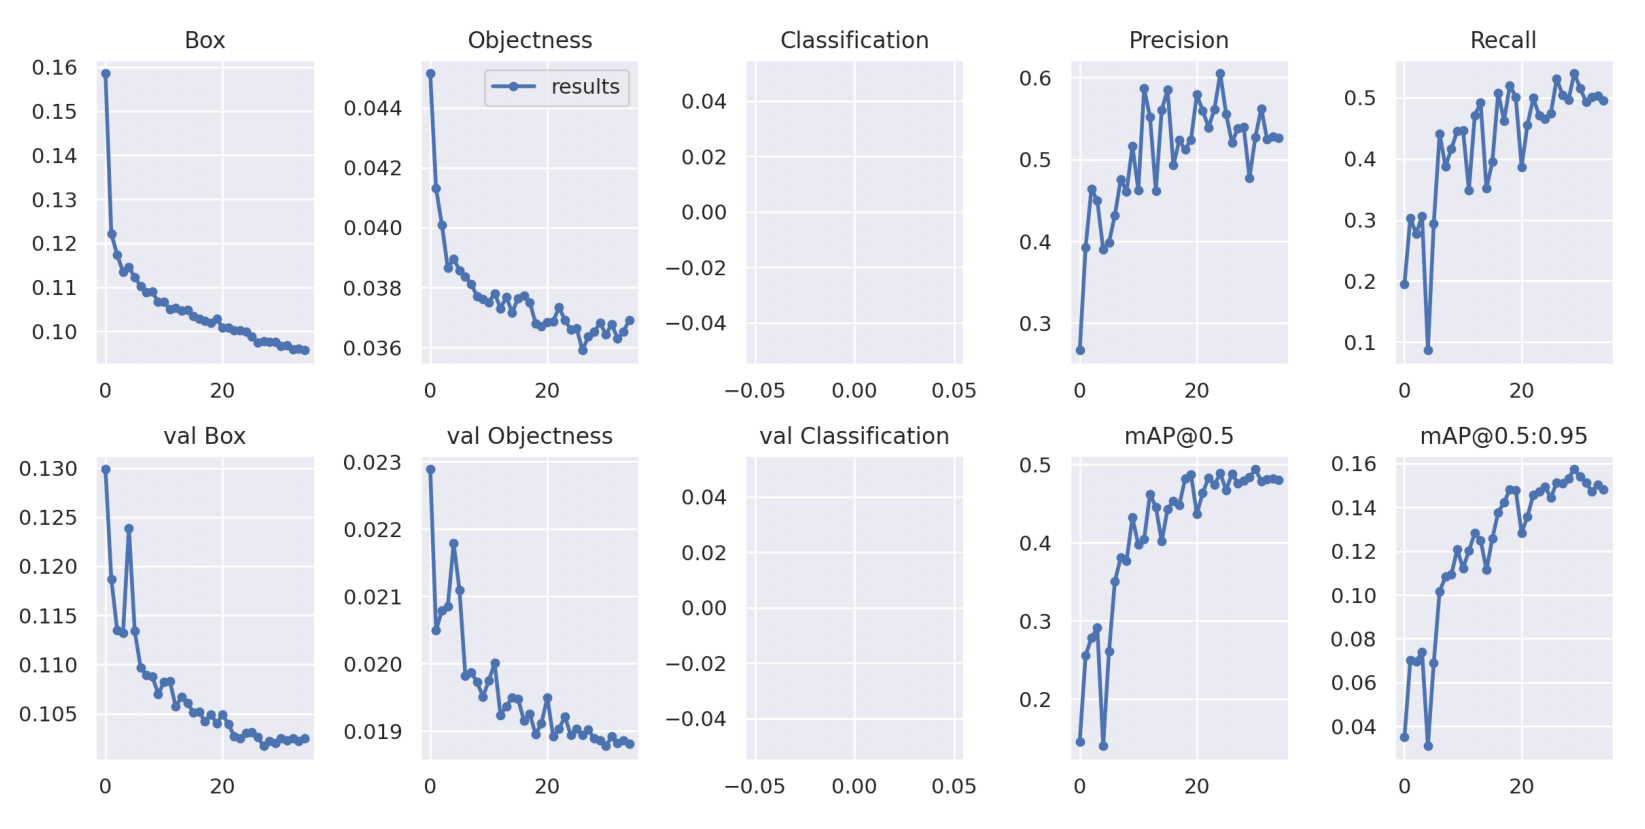

In [77]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp5/results.png'))

# Confusion Matrix

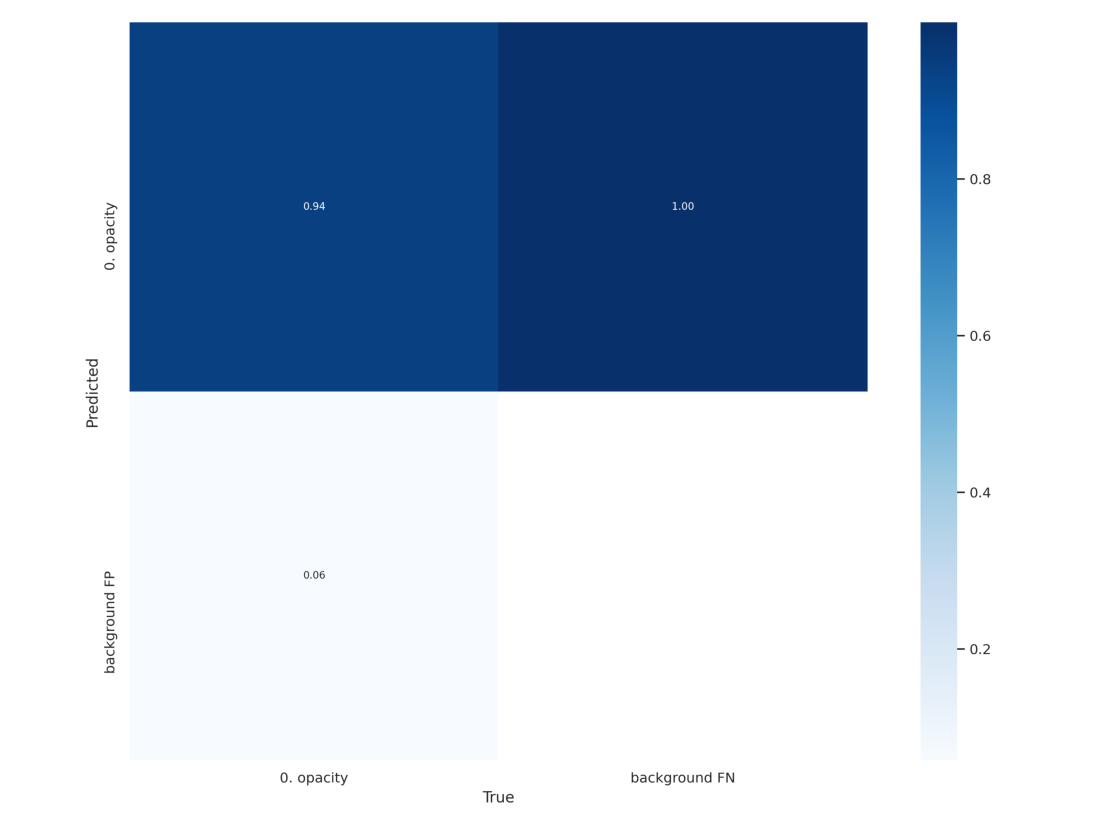

In [78]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp5/confusion_matrix.png'))

# Inference

In [82]:
# 현재 yolov5s 로 학습한 모델
os.chdir('/kaggle/working/yolov5')
!python detect.py --weights '/kaggle/working/yolov5/runs/train/exp5/weights/best.pt'\
--img 512\
--conf 0.1\
--iou 0.5\
--source /kaggle/working/siim-cov19/images/val\
--exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=True, img_size=512, iou_thres=0.5, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/working/siim-cov19/images/val', update=False, view_img=False, weights=['/kaggle/working/yolov5/runs/train/exp5/weights/best.pt'])
Fusing layers... 
image 1/1266 /kaggle/working/siim-cov19/images/val/000a312787f2_image.png: 512x512 2 0. opacitys, Done. (0.021s)
image 2/1266 /kaggle/working/siim-cov19/images/val/0012ff7358bc_image.png: 512x512 2 0. opacitys, Done. (0.023s)
image 3/1266 /kaggle/working/siim-cov19/images/val/00326161e51e_image.png: 512x512 2 0. opacitys, Done. (0.022s)
image 4/1266 /kaggle/working/siim-cov19/images/val/0049814626c8_image.png: 512x512 2 0. opacitys, Done. (0.021s)
image 5/1266 /kaggle/working/siim-cov19/images/val/004cbd797cd1_image.png: 512x512 3 0. opacitys, Done. (0.021s)
image 6/1266 /kaggle/working/siim-cov19/images/val/00b8180bd3a8_image.png

# Inference Plot

100%|██████████| 16/16 [00:00<00:00, 110.42it/s]


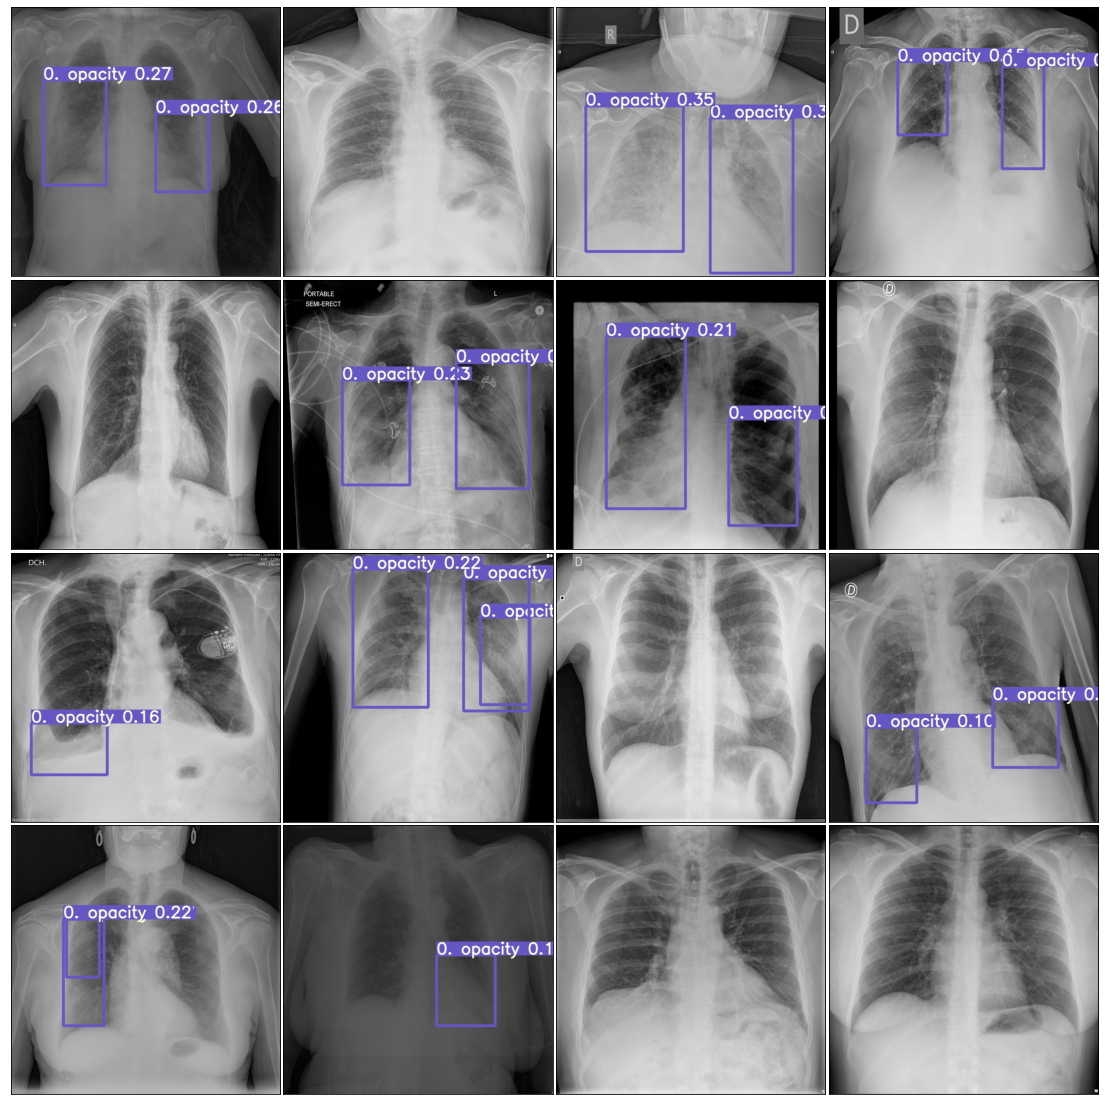

100%|██████████| 16/16 [00:00<00:00, 136.29it/s]


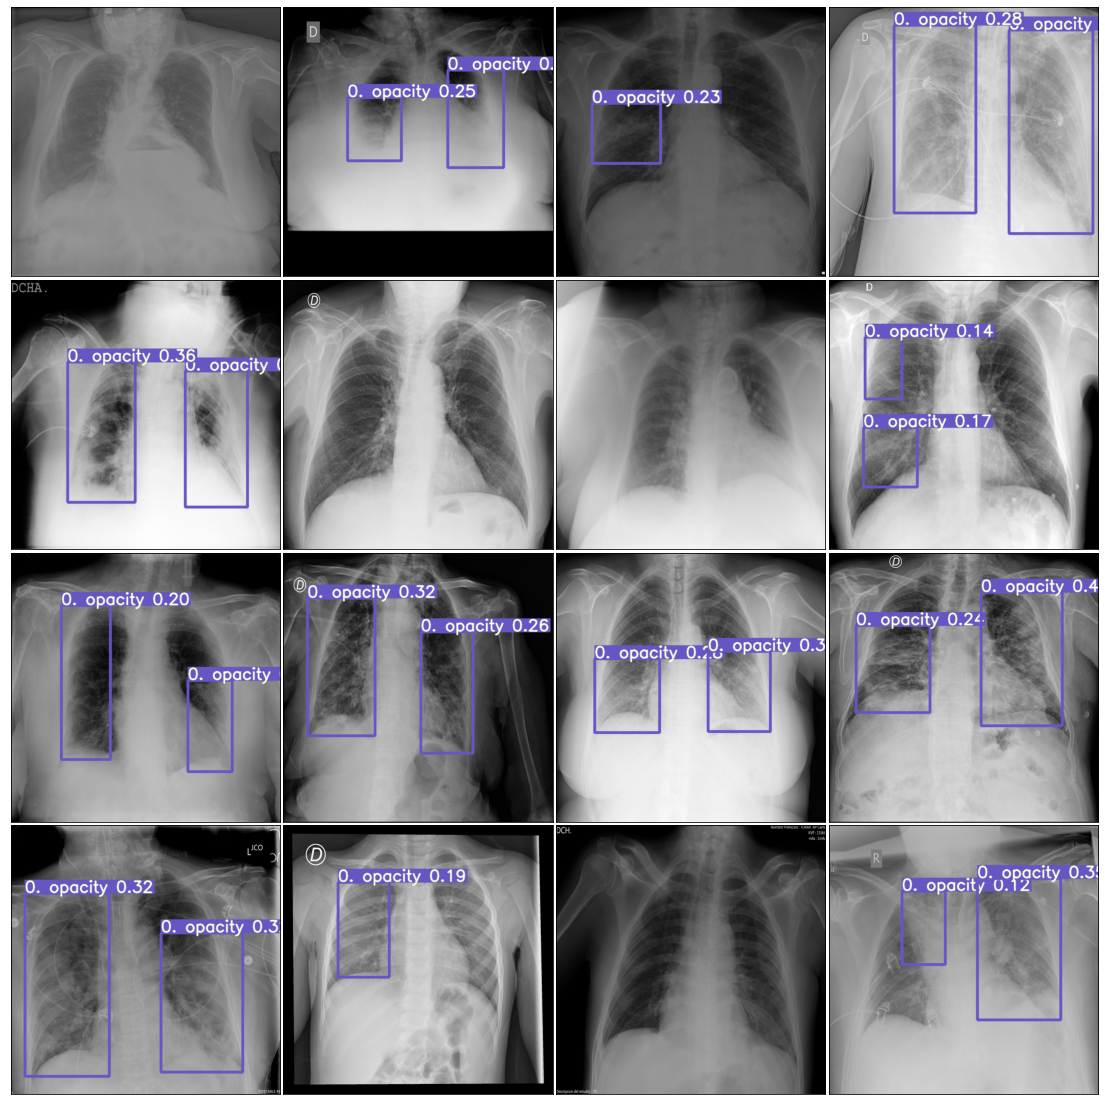

100%|██████████| 16/16 [00:00<00:00, 129.60it/s]


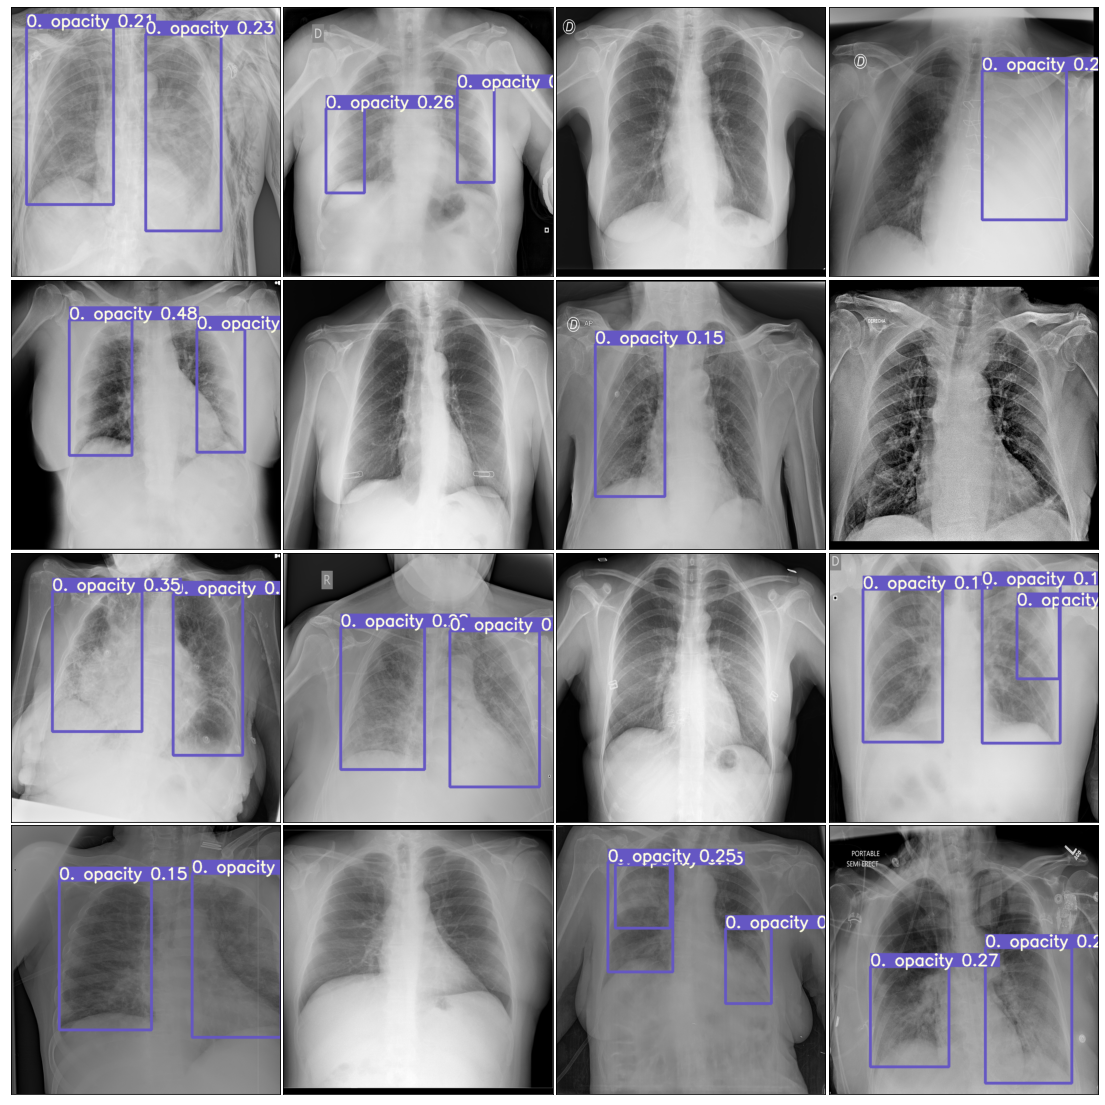

In [87]:
from mpl_toolkits.axes_grid1 import ImageGrid
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('/kaggle/working/yolov5/runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images = []
    for image_path in tqdm(grid_files):
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)
    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
# shutil.rmtree('/kaggle/working/siim-cov19')
# shutil.rmtree('/kaggle/working/yolov5/runs/detect')
# for file in (glob('runs/train/exp/**/*.png', recursive = True)+glob('runs/train/exp/**/*.jpg', recursive = True)):
#     os.remove(file)